# $R_S$ vs. $R_N$ and $R_{NNS}$ vs. $R_{NS}$  barplots for each genome

In [2]:
%run "Header.ipynb"

In [3]:
import json
import pickle
import skbio
import pileup
from statistics import median
from math import log
from collections import defaultdict
from matplotlib import pyplot
from parse_sco import parse_sco

In [4]:
with open("matrix-jsons/seq2gene2codon2alignedcodons.json", "r") as jf:
    seq2gene2codon2alignedcodons = json.load(jf)

In [5]:
seq2gene2codon2alignedcodons["edge_6104"]["1"]

{'266': {'TAA': 4797, 'AAA': 2, 'TTA': 1, 'TCA': 1, 'TAT': 1, 'TAC': 1},
 '269': {'GTA': 4779, 'TGA': 1, 'GTT': 1, 'CTA': 1},
 '272': {'TTG': 4728, 'TGG': 1, 'TTT': 7, 'GTG': 1},
 '275': {'AAT': 4744, 'ATT': 1, 'AAA': 8, 'CAT': 1, 'AAC': 1},
 '278': {'GCA': 4786, 'TCA': 1, 'GCC': 1},
 '281': {'AAG': 4776, 'AGG': 1, 'ATG': 2, 'CAG': 1, 'ACG': 1},
 '284': {'GTA': 4811, 'ACA': 1},
 '287': {'CTT': 4804, 'CGT': 1, 'CAT': 1, 'CTG': 1, 'TCT': 1},
 '290': {'ATG': 4813, 'TTG': 1, 'AAG': 5},
 '293': {'GCT': 4815, 'GCA': 1, 'GCG': 1, 'GAT': 1},
 '296': {'TAT': 4786, 'TTT': 1, 'AGT': 1},
 '299': {'CTT': 4822, 'CTC': 1, 'CAT': 1},
 '302': {'ATT': 4810, 'CTT': 1},
 '305': {'GTG': 4819, 'TTG': 1, 'GAG': 1, 'GGA': 1},
 '308': {'TTT': 4809, 'TTG': 2, 'GTT': 1},
 '311': {'ATG': 4805, 'ATT': 3, 'CTG': 2, 'TAG': 1},
 '314': {'ATA': 4827},
 '317': {'ATT': 4804, 'AAT': 2, 'CTT': 1},
 '320': {'ACA': 4821, 'ACT': 1, 'ACC': 1, 'CCA': 1},
 '323': {'CCT': 4737, 'CAT': 1},
 '326': {'GTC': 4813, 'GTT': 2, 'GTA': 1

## Percentages (values of $p$) for naive mutation calling

### Values we use for plotting
Currently the same as in the codon mutation notebook. I guess these should be a shared variable, ideally? But that might be too much work for its own good.

In [6]:
percentages = [2, 1, 0.5, 0.25, 0.15]

### Full values, used for plotting a FDR curve elsewhere

Copied from the target/decoy notebook. may be nice to generalize to shared code too i guess

In [7]:
# Percentages go from 5%, 4.99%, 4.98%, ..., 0.02%, 0.01%, 0%
full_percentages = [p / 100 for p in range(0, 501, 1)][::-1]
print(f"First two percentages: {full_percentages[:2]}")
print(f"Last two percentages: {full_percentages[-2:]}")
print(f"Number of percentages: {len(full_percentages):,}")

First two percentages: [5.0, 4.99]
Last two percentages: [0.01, 0.0]
Number of percentages: 501


In [8]:
# Sanity check -- we can just compute this data for all of the stuff in full_percentages
# and then for the stuff we wanna plot in this notebook just focus on the values in percentages
for p in percentages:
    assert p in full_percentages, f"{p}% not in full_percentages"

## Define the number of "potential" synonymous / nonsynonymous and non-nonse / nonsense single-nucleotide mutations for each codon

From the paper:

> Of the 64 unique DNA codons, each codon i has Si synonymous and Ni nonsynonymous
single-nucleotide mutations into other codons. For all i, Si + Ni = 9. For example, in the
standard genetic code the codon GGG encoding Glycine has Si = 3 synonymous singlenucleotide mutations (GGT, GGC, GGA) and Ni = 6 nonsynonymous single-nucleotide
mutations (AGG, CGG, TGG, GAG, GCG, GTG).

In [9]:
# This list contains all 64 DNA codons (AAA, AAC, ..., TTT).
codons = []
for i in "ACGT":
    for j in "ACGT":
        for k in "ACGT":
            codons.append(i + j + k)

# Maps the 64 DNA codons in "codons" above to integers: the number of potential single-nucleotide...
# synonymous mutations
c2si = {}
# nonsynonymous mutations
c2ni = {}
# non-nonsense mutations
c2nnsi = {}
# nonsense mutations
c2nsi = {}

# c2si[c] + c2ni[c] should equal 9 for all 64 DNA codons c, and
# c2nnsi[c] + c2nsi[c] should also equal 9 for all 61 sense DNA codons c (these two dicts are undefined
# for stop DNA codons, because you can't really have a "nonsense" mutation occur at an extant stop codon --
# that'd be a "nonstop" mutation. See wikipedia: https://en.wikipedia.org/wiki/Nonsense_mutation)
            
# These bools just impact how much we print out during this cell. mostly useful for debugging.
syn_verbose = False
nonsense_verbose = False
codon_verbose = False

for c in codons:
    aa = str(skbio.DNA.translate(skbio.DNA(c)))
    
    si = 0
    ni = 0
    nnsi = 0
    nsi = 0
    
    num_alt_codons_considered = 0
    
    for pos in (0, 1, 2):
        posnt = c[pos]
        for altnt in sorted(set("ACGT") - set(posnt)):
            # it should be possible to do this without checking pos and just
            # using a single fancy slice operation, but this is more foolproof
            # imo and i am nothing if not a fool a lot of the time
            if pos == 0:
                alt_codon = altnt + c[1:]
            elif pos == 1:
                alt_codon = c[0] + altnt + c[2]
            else:
                alt_codon = c[:2] + altnt

            aa2 = str(skbio.DNA.translate(skbio.DNA(alt_codon)))

            prefix = f"{c} ({aa}) -> {alt_codon} ({aa2}) is "
            if aa2 == aa:
                si += 1
                if syn_verbose:
                    print(prefix + "syn")
            else:
                ni += 1
                if syn_verbose:
                    print(prefix + "nonsyn")
            num_alt_codons_considered += 1
            
            # Record NNSi and NSi info for mutations *from* the 61 sense codons
            # (we don't consider codons that are already stop codons)
            if aa != "*":
                if aa2 == "*":
                    # Nonsense mutation!
                    nsi += 1
                    if nonsense_verbose:
                        print(prefix + "nonsense")
                else:
                    # Non-nonsense mutation!
                    nnsi += 1
                    if nonsense_verbose:
                        print(prefix + "non-nonsense")
                        
    # Sanity checks
    if num_alt_codons_considered != 9:
        raise ValueError("each codon should only have 9 alt codons???")
        
    if si + ni != 9:
        raise ValueError(f"For codon {c}, Si + Ni = {si} + {ni} = {si + ni}. should sum to 9???")
        
    if aa != "*":
        if nnsi + nsi != 9:
            raise ValueError(f"For codon {c}, NNSi + NSi = {nnsi} + {nsi} = {nnsi + nsi}. should sum to 9???")
    else:
        if nnsi != 0 or nsi != 0:
            raise ValueError(f"For codon {c}, NNSi and NSi should both be 0, i.e. undefined.")

    # Print info about this codon
    if codon_verbose:
        print(f"{c} ({aa}) has:\n\t{si} synonymous and {ni} nonsynonymous s.n. muts")
        if aa != "*":
            print(f"\t{nnsi} non-nonsense and {nsi} nonsense s.n. muts")
        else:
            print(f"\tThis is a stop codon, so we're not counting (non-)nonsense s.n. muts from this codon")
            
    # Update mappings we will need for later
    c2si[c] = si
    c2ni[c] = ni
    if aa != "*":
        c2nnsi[c] = nnsi
        c2nsi[c] = nsi
        
print(f"sum of Si = {sum(c2si.values())}")
print(f"sum of Ni = {sum(c2ni.values())}")
print(f"sum of NNSi = {sum(c2nnsi.values())}")
print(f"sum of NSi = {sum(c2nsi.values())}")

# Just to back up some of the intro to this section in the paper...
assert c2si["GGG"] == 3 and c2ni["GGG"] == 6

sum of Si = 138
sum of Ni = 438
sum of NNSi = 526
sum of NSi = 23


## Compute numbers of possible and observed single-nucleotide mutations of the types we care about

This takes a while to run. With just a few percentage values it takes a few minutes, but using all of `full_percentages` (i.e. everything from 50% to 0.01% using increments of 0.01%) it takes around an hour, I think.

... update, not sure how limiting the top to 5% helps

In [19]:
# Compute "N", the total length of all nucleotides in all codons in all predicted genes in each genome
# This allows for positions to be counted multiple times in the case of gene overlaps. Not ideal, I guess,
# but throwing out overlapping sections might bias this against the observation of stop codons.
seq2total_codon_nt_len = {}

# This should be less than N for each genome. It only includes the lengths of sense (i.e. not stop) codons;
# we use this in place of N when doing the (non)nonsense stuff because 
seq2sense_codon_nt_len = {}

# Just needed for misc text stuff later
seq2num_genes = {}

# Possible numbers of single-nucleotide (non)synonymous and (non)nonsense mutations throughout the genomes
seq2poss_si = defaultdict(int)
seq2poss_ni = defaultdict(int)
seq2poss_nnsi = defaultdict(int)
seq2poss_nsi = defaultdict(int)

# For each percentage p in percentages, the observed numbers of the same types of mutations
p2seq2obs_si = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_ni = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_nnsi = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_nsi = {p: defaultdict(int) for p in full_percentages}

for seq in SEQS:
    fasta = skbio.DNA.read(f"../seqs/{seq}.fasta")
    genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
    
    seq2num_genes[seq] = len(genes_df.index)
    
    # We can compute N easily since we already know gene lengths
    seq2total_codon_nt_len[seq] = genes_df["Length"].sum()
    
    # ... but we might as well sanity-check it, since we'll be iterating through all genes anyway
    total_codon_nt_len = 0
    sense_codon_nt_len = 0
    
    for gene_data in genes_df.itertuples():
        print(f"On gene {gene_data.Index:,} / {len(genes_df.index):,} in seq {seq2name[seq]}.")
        for cpleft in range(gene_data.LeftEnd, gene_data.RightEnd + 1, 3):
            
            # Get the exact DNA sequence of this codon
            codon_dna = fasta[cpleft - 1: cpleft + 2]
            if gene_data.Strand == "-":
                codon_dna = codon_dna.reverse_complement()
            codon_seq = str(codon_dna)
            
            # Increment N and N' values, and update numbers of possible single-nucleotide types of mutations
            if str(codon_dna.translate()) != "*":
                sense_codon_nt_len += 3
                seq2poss_nnsi[seq] += c2nnsi[codon_seq]
                seq2poss_nsi[seq] += c2nsi[codon_seq]
                
            total_codon_nt_len += 3
            seq2poss_si[seq] += c2si[codon_seq]
            seq2poss_ni[seq] += c2ni[codon_seq]
            
            # Use codon alignment data (already computed and stored in seq2gene2codon2alignedcodons
            # thanks to the MutationMatrices notebook) to naively call p-mutations at each codon, and thus
            # count "observed" types of single-nucleotide mutations
            aligned_codons = seq2gene2codon2alignedcodons[seq][str(gene_data.Index)][str(cpleft)]
            
            # NOTE this code is copied over from the MutationMatrices notebook -- should eventually generalize
            # to a separate function somewhere
            if len(aligned_codons) > 0:
                max_ac_freq = max(aligned_codons.values())
                if codon_seq in aligned_codons and aligned_codons[codon_seq] == max_ac_freq:
                    num_aligned_codons = sum(aligned_codons.values())
                    # Only call a mutation using the max-freq alt codon, not the sum of all alternate codon freqs.
                    # The max(d, key=d.get) trick is from https://stackoverflow.com/a/280156 (I've used it a lot
                    # here :) Notably, this breaks ties arbitrarily.
                    alt_codons = {c: aligned_codons[c] for c in aligned_codons if c != codon_seq}
                    if len(alt_codons) > 0:
                        max_freq_alt_codon = max(alt_codons, key=aligned_codons.get)
                        max_freq_alt_codon_freq = alt_codons[max_freq_alt_codon]
                    else:
                        # The only codon aligned to this position is the reference codon, so
                        # there's no mutation here.
                        max_freq_alt_codon_freq = 0
                        
                    # So far, so good -- this codon has multiple codons aligned to it, including the reference
                    # codon. So it could have a p-mutation.
                    for p in full_percentages:
                        if p != 0:
                            is_mutation = pileup.naively_call_mutation_directly(max_freq_alt_codon_freq, num_aligned_codons, p)
                        else:
                            # Just call this codon mutated if the alt freq is > 0
                            is_mutation = (max_freq_alt_codon_freq > 0)
                        if is_mutation:
                            # OK, so this is a p-mutation (or p = 0% and we're treating this like a mutation).
                            
                            # If the max freq alt codon is only a single nucleotide different from the
                            # reference codon, update our counts. Otherwise, ignore this codon. (Note that
                            # we're still breaking ties re: "max freq alt codon" arbitrarily; we could change
                            # this a bit if desired, but shouldn't be a big deal.)

                            num_diffs = 0
                            for pos in (0, 1, 2):
                                if max_freq_alt_codon[pos] != codon_seq[pos]:
                                    num_diffs += 1

                            if num_diffs > 1:
                                continue

                            elif num_diffs == 1:
                                # Nice, the max freq alt codon is a single-nucleotide mutation (compared to
                                # the reference codon)!
                                aa = str(codon_dna.translate())
                                aa2 = str(skbio.DNA(max_freq_alt_codon).translate())

                                # Record Syn/NonSyn stuff
                                if aa == aa2:
                                    p2seq2obs_si[p][seq] += 1
                                else:
                                    p2seq2obs_ni[p][seq] += 1

                                # Record Non-nonsense/Nonsense stuff.
                                # We could probs merge this into the second case of the if statement above
                                # but imo the small time savings isn't worth the added complexity of weird code
                                if aa != "*":
                                    if aa2 == "*":
                                        p2seq2obs_nsi[p][seq] += 1
                                    else:
                                        p2seq2obs_nnsi[p][seq] += 1
                            else:
                                # This should never happen, since we filtered out codon_seq from the alt_codons
                                # dict already.
                                raise ValueError(f"Seems like {max_freq_alt_codon} is identical to {codon_seq}???")
    
    # Sanity checks
    if total_codon_nt_len != seq2total_codon_nt_len[seq]:
        raise ValueError(f"Total length of all codons in seq {seq2name[seq]} doesn't seem right?")
        
    # If this check fails, it means Prodigal predicted genes where there were stop codons within the middle
    # of a gene sequence. That's not cool! I guess that could happen in the case of alternate genetic codes,
    # but that shouldn't happen within the context of just this analysis.
    gl3 = len(genes_df.index) * 3
    exp_sense_codon_len = total_codon_nt_len - gl3
    if sense_codon_nt_len != exp_sense_codon_len:
        print(f"Total length of all codons in seq {seq2name[seq]} = {total_codon_nt_len:,}")
        print(f"Total length of all sense codons in seq {seq2name[seq]} = {sense_codon_nt_len:,}")
        print(f"Diff btwn these lengths should be 3 * # genes = 3 * {len(genes_df.index):,} = {gl3:,}")
        print(f"Actual diff is {total_codon_nt_len - sense_codon_nt_len:,}???")
        raise ValueError(f"Length of all sense codons in seq {seq2name[seq]} doesn't seem right?")
    seq2sense_codon_nt_len[seq] = sense_codon_nt_len

On gene 1 / 1,297 in seq CAMP.
On gene 2 / 1,297 in seq CAMP.
On gene 3 / 1,297 in seq CAMP.
On gene 4 / 1,297 in seq CAMP.
On gene 5 / 1,297 in seq CAMP.
On gene 6 / 1,297 in seq CAMP.
On gene 7 / 1,297 in seq CAMP.
On gene 8 / 1,297 in seq CAMP.
On gene 9 / 1,297 in seq CAMP.
On gene 10 / 1,297 in seq CAMP.
On gene 11 / 1,297 in seq CAMP.
On gene 12 / 1,297 in seq CAMP.
On gene 13 / 1,297 in seq CAMP.
On gene 14 / 1,297 in seq CAMP.
On gene 15 / 1,297 in seq CAMP.
On gene 16 / 1,297 in seq CAMP.
On gene 17 / 1,297 in seq CAMP.
On gene 18 / 1,297 in seq CAMP.
On gene 19 / 1,297 in seq CAMP.
On gene 20 / 1,297 in seq CAMP.
On gene 21 / 1,297 in seq CAMP.
On gene 22 / 1,297 in seq CAMP.
On gene 23 / 1,297 in seq CAMP.
On gene 24 / 1,297 in seq CAMP.
On gene 25 / 1,297 in seq CAMP.
On gene 26 / 1,297 in seq CAMP.
On gene 27 / 1,297 in seq CAMP.
On gene 28 / 1,297 in seq CAMP.
On gene 29 / 1,297 in seq CAMP.
On gene 30 / 1,297 in seq CAMP.
On gene 31 / 1,297 in seq CAMP.
On gene 32 / 1,29

On gene 253 / 1,297 in seq CAMP.
On gene 254 / 1,297 in seq CAMP.
On gene 255 / 1,297 in seq CAMP.
On gene 256 / 1,297 in seq CAMP.
On gene 257 / 1,297 in seq CAMP.
On gene 258 / 1,297 in seq CAMP.
On gene 259 / 1,297 in seq CAMP.
On gene 260 / 1,297 in seq CAMP.
On gene 261 / 1,297 in seq CAMP.
On gene 262 / 1,297 in seq CAMP.
On gene 263 / 1,297 in seq CAMP.
On gene 264 / 1,297 in seq CAMP.
On gene 265 / 1,297 in seq CAMP.
On gene 266 / 1,297 in seq CAMP.
On gene 267 / 1,297 in seq CAMP.
On gene 268 / 1,297 in seq CAMP.
On gene 269 / 1,297 in seq CAMP.
On gene 270 / 1,297 in seq CAMP.
On gene 271 / 1,297 in seq CAMP.
On gene 272 / 1,297 in seq CAMP.
On gene 273 / 1,297 in seq CAMP.
On gene 274 / 1,297 in seq CAMP.
On gene 275 / 1,297 in seq CAMP.
On gene 276 / 1,297 in seq CAMP.
On gene 277 / 1,297 in seq CAMP.
On gene 278 / 1,297 in seq CAMP.
On gene 279 / 1,297 in seq CAMP.
On gene 280 / 1,297 in seq CAMP.
On gene 281 / 1,297 in seq CAMP.
On gene 282 / 1,297 in seq CAMP.
On gene 28

On gene 502 / 1,297 in seq CAMP.
On gene 503 / 1,297 in seq CAMP.
On gene 504 / 1,297 in seq CAMP.
On gene 505 / 1,297 in seq CAMP.
On gene 506 / 1,297 in seq CAMP.
On gene 507 / 1,297 in seq CAMP.
On gene 508 / 1,297 in seq CAMP.
On gene 509 / 1,297 in seq CAMP.
On gene 510 / 1,297 in seq CAMP.
On gene 511 / 1,297 in seq CAMP.
On gene 512 / 1,297 in seq CAMP.
On gene 513 / 1,297 in seq CAMP.
On gene 514 / 1,297 in seq CAMP.
On gene 515 / 1,297 in seq CAMP.
On gene 516 / 1,297 in seq CAMP.
On gene 517 / 1,297 in seq CAMP.
On gene 518 / 1,297 in seq CAMP.
On gene 519 / 1,297 in seq CAMP.
On gene 520 / 1,297 in seq CAMP.
On gene 521 / 1,297 in seq CAMP.
On gene 522 / 1,297 in seq CAMP.
On gene 523 / 1,297 in seq CAMP.
On gene 524 / 1,297 in seq CAMP.
On gene 525 / 1,297 in seq CAMP.
On gene 526 / 1,297 in seq CAMP.
On gene 527 / 1,297 in seq CAMP.
On gene 528 / 1,297 in seq CAMP.
On gene 529 / 1,297 in seq CAMP.
On gene 530 / 1,297 in seq CAMP.
On gene 531 / 1,297 in seq CAMP.
On gene 53

On gene 751 / 1,297 in seq CAMP.
On gene 752 / 1,297 in seq CAMP.
On gene 753 / 1,297 in seq CAMP.
On gene 754 / 1,297 in seq CAMP.
On gene 755 / 1,297 in seq CAMP.
On gene 756 / 1,297 in seq CAMP.
On gene 757 / 1,297 in seq CAMP.
On gene 758 / 1,297 in seq CAMP.
On gene 759 / 1,297 in seq CAMP.
On gene 760 / 1,297 in seq CAMP.
On gene 761 / 1,297 in seq CAMP.
On gene 762 / 1,297 in seq CAMP.
On gene 763 / 1,297 in seq CAMP.
On gene 764 / 1,297 in seq CAMP.
On gene 765 / 1,297 in seq CAMP.
On gene 766 / 1,297 in seq CAMP.
On gene 767 / 1,297 in seq CAMP.
On gene 768 / 1,297 in seq CAMP.
On gene 769 / 1,297 in seq CAMP.
On gene 770 / 1,297 in seq CAMP.
On gene 771 / 1,297 in seq CAMP.
On gene 772 / 1,297 in seq CAMP.
On gene 773 / 1,297 in seq CAMP.
On gene 774 / 1,297 in seq CAMP.
On gene 775 / 1,297 in seq CAMP.
On gene 776 / 1,297 in seq CAMP.
On gene 777 / 1,297 in seq CAMP.
On gene 778 / 1,297 in seq CAMP.
On gene 779 / 1,297 in seq CAMP.
On gene 780 / 1,297 in seq CAMP.
On gene 78

On gene 1,004 / 1,297 in seq CAMP.
On gene 1,005 / 1,297 in seq CAMP.
On gene 1,006 / 1,297 in seq CAMP.
On gene 1,007 / 1,297 in seq CAMP.
On gene 1,008 / 1,297 in seq CAMP.
On gene 1,009 / 1,297 in seq CAMP.
On gene 1,010 / 1,297 in seq CAMP.
On gene 1,011 / 1,297 in seq CAMP.
On gene 1,012 / 1,297 in seq CAMP.
On gene 1,013 / 1,297 in seq CAMP.
On gene 1,014 / 1,297 in seq CAMP.
On gene 1,015 / 1,297 in seq CAMP.
On gene 1,016 / 1,297 in seq CAMP.
On gene 1,017 / 1,297 in seq CAMP.
On gene 1,018 / 1,297 in seq CAMP.
On gene 1,019 / 1,297 in seq CAMP.
On gene 1,020 / 1,297 in seq CAMP.
On gene 1,021 / 1,297 in seq CAMP.
On gene 1,022 / 1,297 in seq CAMP.
On gene 1,023 / 1,297 in seq CAMP.
On gene 1,024 / 1,297 in seq CAMP.
On gene 1,025 / 1,297 in seq CAMP.
On gene 1,026 / 1,297 in seq CAMP.
On gene 1,027 / 1,297 in seq CAMP.
On gene 1,028 / 1,297 in seq CAMP.
On gene 1,029 / 1,297 in seq CAMP.
On gene 1,030 / 1,297 in seq CAMP.
On gene 1,031 / 1,297 in seq CAMP.
On gene 1,032 / 1,29

On gene 1,241 / 1,297 in seq CAMP.
On gene 1,242 / 1,297 in seq CAMP.
On gene 1,243 / 1,297 in seq CAMP.
On gene 1,244 / 1,297 in seq CAMP.
On gene 1,245 / 1,297 in seq CAMP.
On gene 1,246 / 1,297 in seq CAMP.
On gene 1,247 / 1,297 in seq CAMP.
On gene 1,248 / 1,297 in seq CAMP.
On gene 1,249 / 1,297 in seq CAMP.
On gene 1,250 / 1,297 in seq CAMP.
On gene 1,251 / 1,297 in seq CAMP.
On gene 1,252 / 1,297 in seq CAMP.
On gene 1,253 / 1,297 in seq CAMP.
On gene 1,254 / 1,297 in seq CAMP.
On gene 1,255 / 1,297 in seq CAMP.
On gene 1,256 / 1,297 in seq CAMP.
On gene 1,257 / 1,297 in seq CAMP.
On gene 1,258 / 1,297 in seq CAMP.
On gene 1,259 / 1,297 in seq CAMP.
On gene 1,260 / 1,297 in seq CAMP.
On gene 1,261 / 1,297 in seq CAMP.
On gene 1,262 / 1,297 in seq CAMP.
On gene 1,263 / 1,297 in seq CAMP.
On gene 1,264 / 1,297 in seq CAMP.
On gene 1,265 / 1,297 in seq CAMP.
On gene 1,266 / 1,297 in seq CAMP.
On gene 1,267 / 1,297 in seq CAMP.
On gene 1,268 / 1,297 in seq CAMP.
On gene 1,269 / 1,29

On gene 187 / 1,761 in seq BACT1.
On gene 188 / 1,761 in seq BACT1.
On gene 189 / 1,761 in seq BACT1.
On gene 190 / 1,761 in seq BACT1.
On gene 191 / 1,761 in seq BACT1.
On gene 192 / 1,761 in seq BACT1.
On gene 193 / 1,761 in seq BACT1.
On gene 194 / 1,761 in seq BACT1.
On gene 195 / 1,761 in seq BACT1.
On gene 196 / 1,761 in seq BACT1.
On gene 197 / 1,761 in seq BACT1.
On gene 198 / 1,761 in seq BACT1.
On gene 199 / 1,761 in seq BACT1.
On gene 200 / 1,761 in seq BACT1.
On gene 201 / 1,761 in seq BACT1.
On gene 202 / 1,761 in seq BACT1.
On gene 203 / 1,761 in seq BACT1.
On gene 204 / 1,761 in seq BACT1.
On gene 205 / 1,761 in seq BACT1.
On gene 206 / 1,761 in seq BACT1.
On gene 207 / 1,761 in seq BACT1.
On gene 208 / 1,761 in seq BACT1.
On gene 209 / 1,761 in seq BACT1.
On gene 210 / 1,761 in seq BACT1.
On gene 211 / 1,761 in seq BACT1.
On gene 212 / 1,761 in seq BACT1.
On gene 213 / 1,761 in seq BACT1.
On gene 214 / 1,761 in seq BACT1.
On gene 215 / 1,761 in seq BACT1.
On gene 216 / 

On gene 428 / 1,761 in seq BACT1.
On gene 429 / 1,761 in seq BACT1.
On gene 430 / 1,761 in seq BACT1.
On gene 431 / 1,761 in seq BACT1.
On gene 432 / 1,761 in seq BACT1.
On gene 433 / 1,761 in seq BACT1.
On gene 434 / 1,761 in seq BACT1.
On gene 435 / 1,761 in seq BACT1.
On gene 436 / 1,761 in seq BACT1.
On gene 437 / 1,761 in seq BACT1.
On gene 438 / 1,761 in seq BACT1.
On gene 439 / 1,761 in seq BACT1.
On gene 440 / 1,761 in seq BACT1.
On gene 441 / 1,761 in seq BACT1.
On gene 442 / 1,761 in seq BACT1.
On gene 443 / 1,761 in seq BACT1.
On gene 444 / 1,761 in seq BACT1.
On gene 445 / 1,761 in seq BACT1.
On gene 446 / 1,761 in seq BACT1.
On gene 447 / 1,761 in seq BACT1.
On gene 448 / 1,761 in seq BACT1.
On gene 449 / 1,761 in seq BACT1.
On gene 450 / 1,761 in seq BACT1.
On gene 451 / 1,761 in seq BACT1.
On gene 452 / 1,761 in seq BACT1.
On gene 453 / 1,761 in seq BACT1.
On gene 454 / 1,761 in seq BACT1.
On gene 455 / 1,761 in seq BACT1.
On gene 456 / 1,761 in seq BACT1.
On gene 457 / 

On gene 669 / 1,761 in seq BACT1.
On gene 670 / 1,761 in seq BACT1.
On gene 671 / 1,761 in seq BACT1.
On gene 672 / 1,761 in seq BACT1.
On gene 673 / 1,761 in seq BACT1.
On gene 674 / 1,761 in seq BACT1.
On gene 675 / 1,761 in seq BACT1.
On gene 676 / 1,761 in seq BACT1.
On gene 677 / 1,761 in seq BACT1.
On gene 678 / 1,761 in seq BACT1.
On gene 679 / 1,761 in seq BACT1.
On gene 680 / 1,761 in seq BACT1.
On gene 681 / 1,761 in seq BACT1.
On gene 682 / 1,761 in seq BACT1.
On gene 683 / 1,761 in seq BACT1.
On gene 684 / 1,761 in seq BACT1.
On gene 685 / 1,761 in seq BACT1.
On gene 686 / 1,761 in seq BACT1.
On gene 687 / 1,761 in seq BACT1.
On gene 688 / 1,761 in seq BACT1.
On gene 689 / 1,761 in seq BACT1.
On gene 690 / 1,761 in seq BACT1.
On gene 691 / 1,761 in seq BACT1.
On gene 692 / 1,761 in seq BACT1.
On gene 693 / 1,761 in seq BACT1.
On gene 694 / 1,761 in seq BACT1.
On gene 695 / 1,761 in seq BACT1.
On gene 696 / 1,761 in seq BACT1.
On gene 697 / 1,761 in seq BACT1.
On gene 698 / 

On gene 912 / 1,761 in seq BACT1.
On gene 913 / 1,761 in seq BACT1.
On gene 914 / 1,761 in seq BACT1.
On gene 915 / 1,761 in seq BACT1.
On gene 916 / 1,761 in seq BACT1.
On gene 917 / 1,761 in seq BACT1.
On gene 918 / 1,761 in seq BACT1.
On gene 919 / 1,761 in seq BACT1.
On gene 920 / 1,761 in seq BACT1.
On gene 921 / 1,761 in seq BACT1.
On gene 922 / 1,761 in seq BACT1.
On gene 923 / 1,761 in seq BACT1.
On gene 924 / 1,761 in seq BACT1.
On gene 925 / 1,761 in seq BACT1.
On gene 926 / 1,761 in seq BACT1.
On gene 927 / 1,761 in seq BACT1.
On gene 928 / 1,761 in seq BACT1.
On gene 929 / 1,761 in seq BACT1.
On gene 930 / 1,761 in seq BACT1.
On gene 931 / 1,761 in seq BACT1.
On gene 932 / 1,761 in seq BACT1.
On gene 933 / 1,761 in seq BACT1.
On gene 934 / 1,761 in seq BACT1.
On gene 935 / 1,761 in seq BACT1.
On gene 936 / 1,761 in seq BACT1.
On gene 937 / 1,761 in seq BACT1.
On gene 938 / 1,761 in seq BACT1.
On gene 939 / 1,761 in seq BACT1.
On gene 940 / 1,761 in seq BACT1.
On gene 941 / 

On gene 1,145 / 1,761 in seq BACT1.
On gene 1,146 / 1,761 in seq BACT1.
On gene 1,147 / 1,761 in seq BACT1.
On gene 1,148 / 1,761 in seq BACT1.
On gene 1,149 / 1,761 in seq BACT1.
On gene 1,150 / 1,761 in seq BACT1.
On gene 1,151 / 1,761 in seq BACT1.
On gene 1,152 / 1,761 in seq BACT1.
On gene 1,153 / 1,761 in seq BACT1.
On gene 1,154 / 1,761 in seq BACT1.
On gene 1,155 / 1,761 in seq BACT1.
On gene 1,156 / 1,761 in seq BACT1.
On gene 1,157 / 1,761 in seq BACT1.
On gene 1,158 / 1,761 in seq BACT1.
On gene 1,159 / 1,761 in seq BACT1.
On gene 1,160 / 1,761 in seq BACT1.
On gene 1,161 / 1,761 in seq BACT1.
On gene 1,162 / 1,761 in seq BACT1.
On gene 1,163 / 1,761 in seq BACT1.
On gene 1,164 / 1,761 in seq BACT1.
On gene 1,165 / 1,761 in seq BACT1.
On gene 1,166 / 1,761 in seq BACT1.
On gene 1,167 / 1,761 in seq BACT1.
On gene 1,168 / 1,761 in seq BACT1.
On gene 1,169 / 1,761 in seq BACT1.
On gene 1,170 / 1,761 in seq BACT1.
On gene 1,171 / 1,761 in seq BACT1.
On gene 1,172 / 1,761 in seq

On gene 1,374 / 1,761 in seq BACT1.
On gene 1,375 / 1,761 in seq BACT1.
On gene 1,376 / 1,761 in seq BACT1.
On gene 1,377 / 1,761 in seq BACT1.
On gene 1,378 / 1,761 in seq BACT1.
On gene 1,379 / 1,761 in seq BACT1.
On gene 1,380 / 1,761 in seq BACT1.
On gene 1,381 / 1,761 in seq BACT1.
On gene 1,382 / 1,761 in seq BACT1.
On gene 1,383 / 1,761 in seq BACT1.
On gene 1,384 / 1,761 in seq BACT1.
On gene 1,385 / 1,761 in seq BACT1.
On gene 1,386 / 1,761 in seq BACT1.
On gene 1,387 / 1,761 in seq BACT1.
On gene 1,388 / 1,761 in seq BACT1.
On gene 1,389 / 1,761 in seq BACT1.
On gene 1,390 / 1,761 in seq BACT1.
On gene 1,391 / 1,761 in seq BACT1.
On gene 1,392 / 1,761 in seq BACT1.
On gene 1,393 / 1,761 in seq BACT1.
On gene 1,394 / 1,761 in seq BACT1.
On gene 1,395 / 1,761 in seq BACT1.
On gene 1,396 / 1,761 in seq BACT1.
On gene 1,397 / 1,761 in seq BACT1.
On gene 1,398 / 1,761 in seq BACT1.
On gene 1,399 / 1,761 in seq BACT1.
On gene 1,400 / 1,761 in seq BACT1.
On gene 1,401 / 1,761 in seq

On gene 1,602 / 1,761 in seq BACT1.
On gene 1,603 / 1,761 in seq BACT1.
On gene 1,604 / 1,761 in seq BACT1.
On gene 1,605 / 1,761 in seq BACT1.
On gene 1,606 / 1,761 in seq BACT1.
On gene 1,607 / 1,761 in seq BACT1.
On gene 1,608 / 1,761 in seq BACT1.
On gene 1,609 / 1,761 in seq BACT1.
On gene 1,610 / 1,761 in seq BACT1.
On gene 1,611 / 1,761 in seq BACT1.
On gene 1,612 / 1,761 in seq BACT1.
On gene 1,613 / 1,761 in seq BACT1.
On gene 1,614 / 1,761 in seq BACT1.
On gene 1,615 / 1,761 in seq BACT1.
On gene 1,616 / 1,761 in seq BACT1.
On gene 1,617 / 1,761 in seq BACT1.
On gene 1,618 / 1,761 in seq BACT1.
On gene 1,619 / 1,761 in seq BACT1.
On gene 1,620 / 1,761 in seq BACT1.
On gene 1,621 / 1,761 in seq BACT1.
On gene 1,622 / 1,761 in seq BACT1.
On gene 1,623 / 1,761 in seq BACT1.
On gene 1,624 / 1,761 in seq BACT1.
On gene 1,625 / 1,761 in seq BACT1.
On gene 1,626 / 1,761 in seq BACT1.
On gene 1,627 / 1,761 in seq BACT1.
On gene 1,628 / 1,761 in seq BACT1.
On gene 1,629 / 1,761 in seq

On gene 77 / 2,567 in seq BACT2.
On gene 78 / 2,567 in seq BACT2.
On gene 79 / 2,567 in seq BACT2.
On gene 80 / 2,567 in seq BACT2.
On gene 81 / 2,567 in seq BACT2.
On gene 82 / 2,567 in seq BACT2.
On gene 83 / 2,567 in seq BACT2.
On gene 84 / 2,567 in seq BACT2.
On gene 85 / 2,567 in seq BACT2.
On gene 86 / 2,567 in seq BACT2.
On gene 87 / 2,567 in seq BACT2.
On gene 88 / 2,567 in seq BACT2.
On gene 89 / 2,567 in seq BACT2.
On gene 90 / 2,567 in seq BACT2.
On gene 91 / 2,567 in seq BACT2.
On gene 92 / 2,567 in seq BACT2.
On gene 93 / 2,567 in seq BACT2.
On gene 94 / 2,567 in seq BACT2.
On gene 95 / 2,567 in seq BACT2.
On gene 96 / 2,567 in seq BACT2.
On gene 97 / 2,567 in seq BACT2.
On gene 98 / 2,567 in seq BACT2.
On gene 99 / 2,567 in seq BACT2.
On gene 100 / 2,567 in seq BACT2.
On gene 101 / 2,567 in seq BACT2.
On gene 102 / 2,567 in seq BACT2.
On gene 103 / 2,567 in seq BACT2.
On gene 104 / 2,567 in seq BACT2.
On gene 105 / 2,567 in seq BACT2.
On gene 106 / 2,567 in seq BACT2.
On 

On gene 319 / 2,567 in seq BACT2.
On gene 320 / 2,567 in seq BACT2.
On gene 321 / 2,567 in seq BACT2.
On gene 322 / 2,567 in seq BACT2.
On gene 323 / 2,567 in seq BACT2.
On gene 324 / 2,567 in seq BACT2.
On gene 325 / 2,567 in seq BACT2.
On gene 326 / 2,567 in seq BACT2.
On gene 327 / 2,567 in seq BACT2.
On gene 328 / 2,567 in seq BACT2.
On gene 329 / 2,567 in seq BACT2.
On gene 330 / 2,567 in seq BACT2.
On gene 331 / 2,567 in seq BACT2.
On gene 332 / 2,567 in seq BACT2.
On gene 333 / 2,567 in seq BACT2.
On gene 334 / 2,567 in seq BACT2.
On gene 335 / 2,567 in seq BACT2.
On gene 336 / 2,567 in seq BACT2.
On gene 337 / 2,567 in seq BACT2.
On gene 338 / 2,567 in seq BACT2.
On gene 339 / 2,567 in seq BACT2.
On gene 340 / 2,567 in seq BACT2.
On gene 341 / 2,567 in seq BACT2.
On gene 342 / 2,567 in seq BACT2.
On gene 343 / 2,567 in seq BACT2.
On gene 344 / 2,567 in seq BACT2.
On gene 345 / 2,567 in seq BACT2.
On gene 346 / 2,567 in seq BACT2.
On gene 347 / 2,567 in seq BACT2.
On gene 348 / 

On gene 560 / 2,567 in seq BACT2.
On gene 561 / 2,567 in seq BACT2.
On gene 562 / 2,567 in seq BACT2.
On gene 563 / 2,567 in seq BACT2.
On gene 564 / 2,567 in seq BACT2.
On gene 565 / 2,567 in seq BACT2.
On gene 566 / 2,567 in seq BACT2.
On gene 567 / 2,567 in seq BACT2.
On gene 568 / 2,567 in seq BACT2.
On gene 569 / 2,567 in seq BACT2.
On gene 570 / 2,567 in seq BACT2.
On gene 571 / 2,567 in seq BACT2.
On gene 572 / 2,567 in seq BACT2.
On gene 573 / 2,567 in seq BACT2.
On gene 574 / 2,567 in seq BACT2.
On gene 575 / 2,567 in seq BACT2.
On gene 576 / 2,567 in seq BACT2.
On gene 577 / 2,567 in seq BACT2.
On gene 578 / 2,567 in seq BACT2.
On gene 579 / 2,567 in seq BACT2.
On gene 580 / 2,567 in seq BACT2.
On gene 581 / 2,567 in seq BACT2.
On gene 582 / 2,567 in seq BACT2.
On gene 583 / 2,567 in seq BACT2.
On gene 584 / 2,567 in seq BACT2.
On gene 585 / 2,567 in seq BACT2.
On gene 586 / 2,567 in seq BACT2.
On gene 587 / 2,567 in seq BACT2.
On gene 588 / 2,567 in seq BACT2.
On gene 589 / 

On gene 803 / 2,567 in seq BACT2.
On gene 804 / 2,567 in seq BACT2.
On gene 805 / 2,567 in seq BACT2.
On gene 806 / 2,567 in seq BACT2.
On gene 807 / 2,567 in seq BACT2.
On gene 808 / 2,567 in seq BACT2.
On gene 809 / 2,567 in seq BACT2.
On gene 810 / 2,567 in seq BACT2.
On gene 811 / 2,567 in seq BACT2.
On gene 812 / 2,567 in seq BACT2.
On gene 813 / 2,567 in seq BACT2.
On gene 814 / 2,567 in seq BACT2.
On gene 815 / 2,567 in seq BACT2.
On gene 816 / 2,567 in seq BACT2.
On gene 817 / 2,567 in seq BACT2.
On gene 818 / 2,567 in seq BACT2.
On gene 819 / 2,567 in seq BACT2.
On gene 820 / 2,567 in seq BACT2.
On gene 821 / 2,567 in seq BACT2.
On gene 822 / 2,567 in seq BACT2.
On gene 823 / 2,567 in seq BACT2.
On gene 824 / 2,567 in seq BACT2.
On gene 825 / 2,567 in seq BACT2.
On gene 826 / 2,567 in seq BACT2.
On gene 827 / 2,567 in seq BACT2.
On gene 828 / 2,567 in seq BACT2.
On gene 829 / 2,567 in seq BACT2.
On gene 830 / 2,567 in seq BACT2.
On gene 831 / 2,567 in seq BACT2.
On gene 832 / 

On gene 1,043 / 2,567 in seq BACT2.
On gene 1,044 / 2,567 in seq BACT2.
On gene 1,045 / 2,567 in seq BACT2.
On gene 1,046 / 2,567 in seq BACT2.
On gene 1,047 / 2,567 in seq BACT2.
On gene 1,048 / 2,567 in seq BACT2.
On gene 1,049 / 2,567 in seq BACT2.
On gene 1,050 / 2,567 in seq BACT2.
On gene 1,051 / 2,567 in seq BACT2.
On gene 1,052 / 2,567 in seq BACT2.
On gene 1,053 / 2,567 in seq BACT2.
On gene 1,054 / 2,567 in seq BACT2.
On gene 1,055 / 2,567 in seq BACT2.
On gene 1,056 / 2,567 in seq BACT2.
On gene 1,057 / 2,567 in seq BACT2.
On gene 1,058 / 2,567 in seq BACT2.
On gene 1,059 / 2,567 in seq BACT2.
On gene 1,060 / 2,567 in seq BACT2.
On gene 1,061 / 2,567 in seq BACT2.
On gene 1,062 / 2,567 in seq BACT2.
On gene 1,063 / 2,567 in seq BACT2.
On gene 1,064 / 2,567 in seq BACT2.
On gene 1,065 / 2,567 in seq BACT2.
On gene 1,066 / 2,567 in seq BACT2.
On gene 1,067 / 2,567 in seq BACT2.
On gene 1,068 / 2,567 in seq BACT2.
On gene 1,069 / 2,567 in seq BACT2.
On gene 1,070 / 2,567 in seq

On gene 1,272 / 2,567 in seq BACT2.
On gene 1,273 / 2,567 in seq BACT2.
On gene 1,274 / 2,567 in seq BACT2.
On gene 1,275 / 2,567 in seq BACT2.
On gene 1,276 / 2,567 in seq BACT2.
On gene 1,277 / 2,567 in seq BACT2.
On gene 1,278 / 2,567 in seq BACT2.
On gene 1,279 / 2,567 in seq BACT2.
On gene 1,280 / 2,567 in seq BACT2.
On gene 1,281 / 2,567 in seq BACT2.
On gene 1,282 / 2,567 in seq BACT2.
On gene 1,283 / 2,567 in seq BACT2.
On gene 1,284 / 2,567 in seq BACT2.
On gene 1,285 / 2,567 in seq BACT2.
On gene 1,286 / 2,567 in seq BACT2.
On gene 1,287 / 2,567 in seq BACT2.
On gene 1,288 / 2,567 in seq BACT2.
On gene 1,289 / 2,567 in seq BACT2.
On gene 1,290 / 2,567 in seq BACT2.
On gene 1,291 / 2,567 in seq BACT2.
On gene 1,292 / 2,567 in seq BACT2.
On gene 1,293 / 2,567 in seq BACT2.
On gene 1,294 / 2,567 in seq BACT2.
On gene 1,295 / 2,567 in seq BACT2.
On gene 1,296 / 2,567 in seq BACT2.
On gene 1,297 / 2,567 in seq BACT2.
On gene 1,298 / 2,567 in seq BACT2.
On gene 1,299 / 2,567 in seq

On gene 1,500 / 2,567 in seq BACT2.
On gene 1,501 / 2,567 in seq BACT2.
On gene 1,502 / 2,567 in seq BACT2.
On gene 1,503 / 2,567 in seq BACT2.
On gene 1,504 / 2,567 in seq BACT2.
On gene 1,505 / 2,567 in seq BACT2.
On gene 1,506 / 2,567 in seq BACT2.
On gene 1,507 / 2,567 in seq BACT2.
On gene 1,508 / 2,567 in seq BACT2.
On gene 1,509 / 2,567 in seq BACT2.
On gene 1,510 / 2,567 in seq BACT2.
On gene 1,511 / 2,567 in seq BACT2.
On gene 1,512 / 2,567 in seq BACT2.
On gene 1,513 / 2,567 in seq BACT2.
On gene 1,514 / 2,567 in seq BACT2.
On gene 1,515 / 2,567 in seq BACT2.
On gene 1,516 / 2,567 in seq BACT2.
On gene 1,517 / 2,567 in seq BACT2.
On gene 1,518 / 2,567 in seq BACT2.
On gene 1,519 / 2,567 in seq BACT2.
On gene 1,520 / 2,567 in seq BACT2.
On gene 1,521 / 2,567 in seq BACT2.
On gene 1,522 / 2,567 in seq BACT2.
On gene 1,523 / 2,567 in seq BACT2.
On gene 1,524 / 2,567 in seq BACT2.
On gene 1,525 / 2,567 in seq BACT2.
On gene 1,526 / 2,567 in seq BACT2.
On gene 1,527 / 2,567 in seq

On gene 1,728 / 2,567 in seq BACT2.
On gene 1,729 / 2,567 in seq BACT2.
On gene 1,730 / 2,567 in seq BACT2.
On gene 1,731 / 2,567 in seq BACT2.
On gene 1,732 / 2,567 in seq BACT2.
On gene 1,733 / 2,567 in seq BACT2.
On gene 1,734 / 2,567 in seq BACT2.
On gene 1,735 / 2,567 in seq BACT2.
On gene 1,736 / 2,567 in seq BACT2.
On gene 1,737 / 2,567 in seq BACT2.
On gene 1,738 / 2,567 in seq BACT2.
On gene 1,739 / 2,567 in seq BACT2.
On gene 1,740 / 2,567 in seq BACT2.
On gene 1,741 / 2,567 in seq BACT2.
On gene 1,742 / 2,567 in seq BACT2.
On gene 1,743 / 2,567 in seq BACT2.
On gene 1,744 / 2,567 in seq BACT2.
On gene 1,745 / 2,567 in seq BACT2.
On gene 1,746 / 2,567 in seq BACT2.
On gene 1,747 / 2,567 in seq BACT2.
On gene 1,748 / 2,567 in seq BACT2.
On gene 1,749 / 2,567 in seq BACT2.
On gene 1,750 / 2,567 in seq BACT2.
On gene 1,751 / 2,567 in seq BACT2.
On gene 1,752 / 2,567 in seq BACT2.
On gene 1,753 / 2,567 in seq BACT2.
On gene 1,754 / 2,567 in seq BACT2.
On gene 1,755 / 2,567 in seq

On gene 1,956 / 2,567 in seq BACT2.
On gene 1,957 / 2,567 in seq BACT2.
On gene 1,958 / 2,567 in seq BACT2.
On gene 1,959 / 2,567 in seq BACT2.
On gene 1,960 / 2,567 in seq BACT2.
On gene 1,961 / 2,567 in seq BACT2.
On gene 1,962 / 2,567 in seq BACT2.
On gene 1,963 / 2,567 in seq BACT2.
On gene 1,964 / 2,567 in seq BACT2.
On gene 1,965 / 2,567 in seq BACT2.
On gene 1,966 / 2,567 in seq BACT2.
On gene 1,967 / 2,567 in seq BACT2.
On gene 1,968 / 2,567 in seq BACT2.
On gene 1,969 / 2,567 in seq BACT2.
On gene 1,970 / 2,567 in seq BACT2.
On gene 1,971 / 2,567 in seq BACT2.
On gene 1,972 / 2,567 in seq BACT2.
On gene 1,973 / 2,567 in seq BACT2.
On gene 1,974 / 2,567 in seq BACT2.
On gene 1,975 / 2,567 in seq BACT2.
On gene 1,976 / 2,567 in seq BACT2.
On gene 1,977 / 2,567 in seq BACT2.
On gene 1,978 / 2,567 in seq BACT2.
On gene 1,979 / 2,567 in seq BACT2.
On gene 1,980 / 2,567 in seq BACT2.
On gene 1,981 / 2,567 in seq BACT2.
On gene 1,982 / 2,567 in seq BACT2.
On gene 1,983 / 2,567 in seq

On gene 2,185 / 2,567 in seq BACT2.
On gene 2,186 / 2,567 in seq BACT2.
On gene 2,187 / 2,567 in seq BACT2.
On gene 2,188 / 2,567 in seq BACT2.
On gene 2,189 / 2,567 in seq BACT2.
On gene 2,190 / 2,567 in seq BACT2.
On gene 2,191 / 2,567 in seq BACT2.
On gene 2,192 / 2,567 in seq BACT2.
On gene 2,193 / 2,567 in seq BACT2.
On gene 2,194 / 2,567 in seq BACT2.
On gene 2,195 / 2,567 in seq BACT2.
On gene 2,196 / 2,567 in seq BACT2.
On gene 2,197 / 2,567 in seq BACT2.
On gene 2,198 / 2,567 in seq BACT2.
On gene 2,199 / 2,567 in seq BACT2.
On gene 2,200 / 2,567 in seq BACT2.
On gene 2,201 / 2,567 in seq BACT2.
On gene 2,202 / 2,567 in seq BACT2.
On gene 2,203 / 2,567 in seq BACT2.
On gene 2,204 / 2,567 in seq BACT2.
On gene 2,205 / 2,567 in seq BACT2.
On gene 2,206 / 2,567 in seq BACT2.
On gene 2,207 / 2,567 in seq BACT2.
On gene 2,208 / 2,567 in seq BACT2.
On gene 2,209 / 2,567 in seq BACT2.
On gene 2,210 / 2,567 in seq BACT2.
On gene 2,211 / 2,567 in seq BACT2.
On gene 2,212 / 2,567 in seq

On gene 2,413 / 2,567 in seq BACT2.
On gene 2,414 / 2,567 in seq BACT2.
On gene 2,415 / 2,567 in seq BACT2.
On gene 2,416 / 2,567 in seq BACT2.
On gene 2,417 / 2,567 in seq BACT2.
On gene 2,418 / 2,567 in seq BACT2.
On gene 2,419 / 2,567 in seq BACT2.
On gene 2,420 / 2,567 in seq BACT2.
On gene 2,421 / 2,567 in seq BACT2.
On gene 2,422 / 2,567 in seq BACT2.
On gene 2,423 / 2,567 in seq BACT2.
On gene 2,424 / 2,567 in seq BACT2.
On gene 2,425 / 2,567 in seq BACT2.
On gene 2,426 / 2,567 in seq BACT2.
On gene 2,427 / 2,567 in seq BACT2.
On gene 2,428 / 2,567 in seq BACT2.
On gene 2,429 / 2,567 in seq BACT2.
On gene 2,430 / 2,567 in seq BACT2.
On gene 2,431 / 2,567 in seq BACT2.
On gene 2,432 / 2,567 in seq BACT2.
On gene 2,433 / 2,567 in seq BACT2.
On gene 2,434 / 2,567 in seq BACT2.
On gene 2,435 / 2,567 in seq BACT2.
On gene 2,436 / 2,567 in seq BACT2.
On gene 2,437 / 2,567 in seq BACT2.
On gene 2,438 / 2,567 in seq BACT2.
On gene 2,439 / 2,567 in seq BACT2.
On gene 2,440 / 2,567 in seq

### Output numbers of observed and possible mutations

Slow to compute since we use a ton of values of $p$, but since these are just numbers of observed mutations -- not coordinates -- doesn't take up a ton of space thankfully.

In [20]:
with open("misc-output/p2seq2obs_si.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_si, pf)
    
with open("misc-output/p2seq2obs_ni.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_ni, pf)
    
with open("misc-output/p2seq2obs_nnsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_nnsi, pf)
    
with open("misc-output/p2seq2obs_nsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_nsi, pf)

with open("misc-output/seq2poss_si.pickle", "wb") as pf:
    pickle.dump(seq2poss_si, pf)
    
with open("misc-output/seq2poss_ni.pickle", "wb") as pf:
    pickle.dump(seq2poss_ni, pf)
    
with open("misc-output/seq2poss_nnsi.pickle", "wb") as pf:
    pickle.dump(seq2poss_nnsi, pf)

with open("misc-output/seq2poss_nsi.pickle", "wb") as pf:
    pickle.dump(seq2poss_nsi, pf)

### Load numbers of observed and possible mutations

So that we could skip the slow step above if desired

In [10]:
def load_pf(basename):
    with open(f"misc-output/{basename}.pickle", "rb") as pf:
        return pickle.load(pf)

p2seq2obs_si = load_pf("p2seq2obs_si")
p2seq2obs_ni = load_pf("p2seq2obs_ni")
p2seq2obs_nnsi = load_pf("p2seq2obs_nnsi")
p2seq2obs_nsi = load_pf("p2seq2obs_nsi")

seq2poss_si = load_pf("seq2poss_si")
seq2poss_ni = load_pf("seq2poss_ni")
seq2poss_nnsi = load_pf("seq2poss_nnsi")
seq2poss_nsi = load_pf("seq2poss_nsi")

## Compute rates based on the above data that are easy to plot

In [11]:
# Rates for synonymous and nonsynonymous s.n. mutations
p2seq2synvals = {p: {} for p in percentages}
# Rates for non-nonsense and nonsense s.n. mutations
p2seq2nonsensevals = {p: {} for p in percentages}

def get_rate(p, seq, p2seq2obs, seq2poss):
    # This should never happen (TM)
    if seq not in seq2poss:
        raise ValueError("No possible mutations of some type defined for this seq?")
        
    if seq not in p2seq2obs[p]:
        rate = 0
    else:
        rate = p2seq2obs[p][seq] / seq2poss[seq]

    return rate

for p in percentages:
    for seq in SEQS:
        p2seq2synvals[p][seq] = {}
        p2seq2synvals[p][seq]["syn"] = get_rate(p, seq, p2seq2obs_si, seq2poss_si)
        p2seq2synvals[p][seq]["nonsyn"] = get_rate(p, seq, p2seq2obs_ni, seq2poss_ni)

        p2seq2nonsensevals[p][seq] = {}
        p2seq2nonsensevals[p][seq]["nonnonsense"] = get_rate(p, seq, p2seq2obs_nnsi, seq2poss_nnsi)
        p2seq2nonsensevals[p][seq]["nonsense"] = get_rate(p, seq, p2seq2obs_nsi, seq2poss_nsi)

## Plot the data

In [12]:
def get_suffix(p):
    # Like in the CP 1/2/3 notebook.
    if p == 0:
        return "alt(codon) > 0"
    else:
         return f"na\u00efve, $p$ = {p}%"

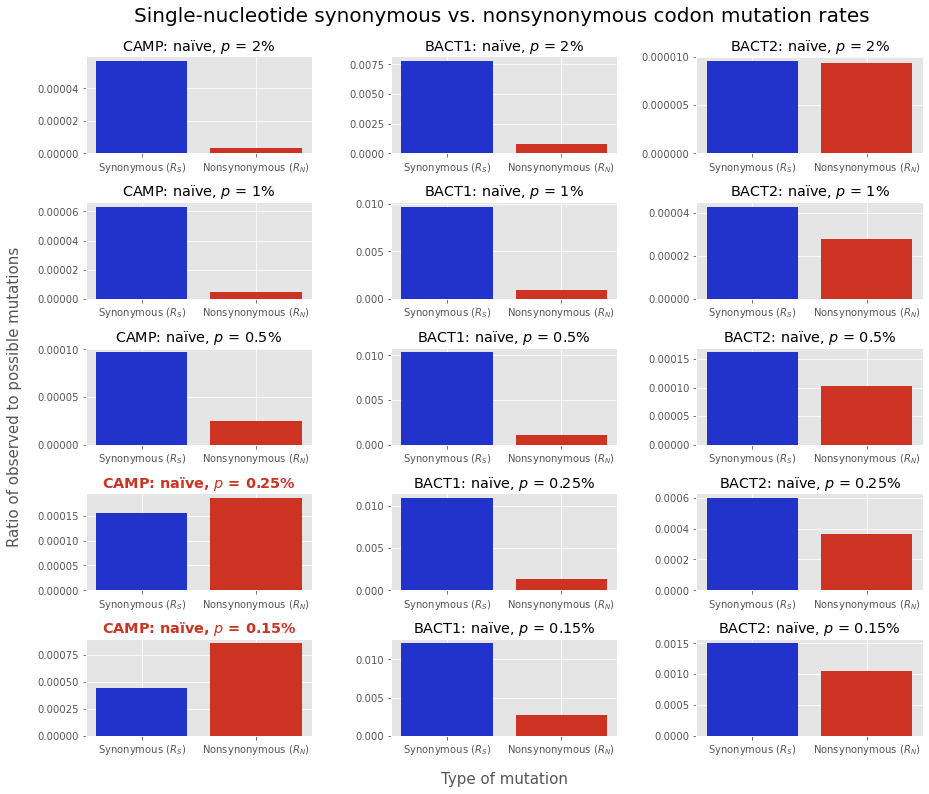

In [62]:
fig, axes = pyplot.subplots(len(percentages), 3, gridspec_kw={"hspace": 0.5, "wspace": 0.35})

if len(percentages) % 2 == 0:
    # Really, the precise middle is between two rows, right? anyway as of writing we use 7 percentages
    # so this never happens
    middle_row = len(percentages) / 2
else:
    middle_row = percentages.index(median(percentages))

for pi, p in enumerate(percentages):
    for si, seq in enumerate(SEQS):
        rs = p2seq2synvals[p][seq]["syn"]
        rn = p2seq2synvals[p][seq]["nonsyn"]
        axes[pi, si].bar(
            ["Synonymous ($R_S$)", "Nonsynonymous ($R_N$)"],
            [rs,rn],
            color=["#2233cc", "#cc3322"]
        )
        axes[pi, si].ticklabel_format(axis="y", style="plain")
        
        titlecolor="#000000"
        titleweight="normal"
        if rs <= rn:
            titlecolor = "#cc3322"
            titleweight = "semibold"
            
        axes[pi, si].set_title(f"{seq2name[seq]}: {get_suffix(p)}", color=titlecolor, fontweight=titleweight)
        
        if pi == middle_row and si == 0:
            axes[pi, si].set_ylabel("Ratio of observed to possible mutations", labelpad=15, fontsize=15)

axes[len(percentages) - 1, 1].set_xlabel("Type of mutation", labelpad=15, fontsize=15)
fig.suptitle("Single-nucleotide synonymous vs. nonsynonymous codon mutation rates", y=0.935, x=0.51, fontsize=20)
fig.set_size_inches(15, 12.5)
fig.savefig("figs/syn-nonsyn-snmut-barplots.png", bbox_inches="tight")

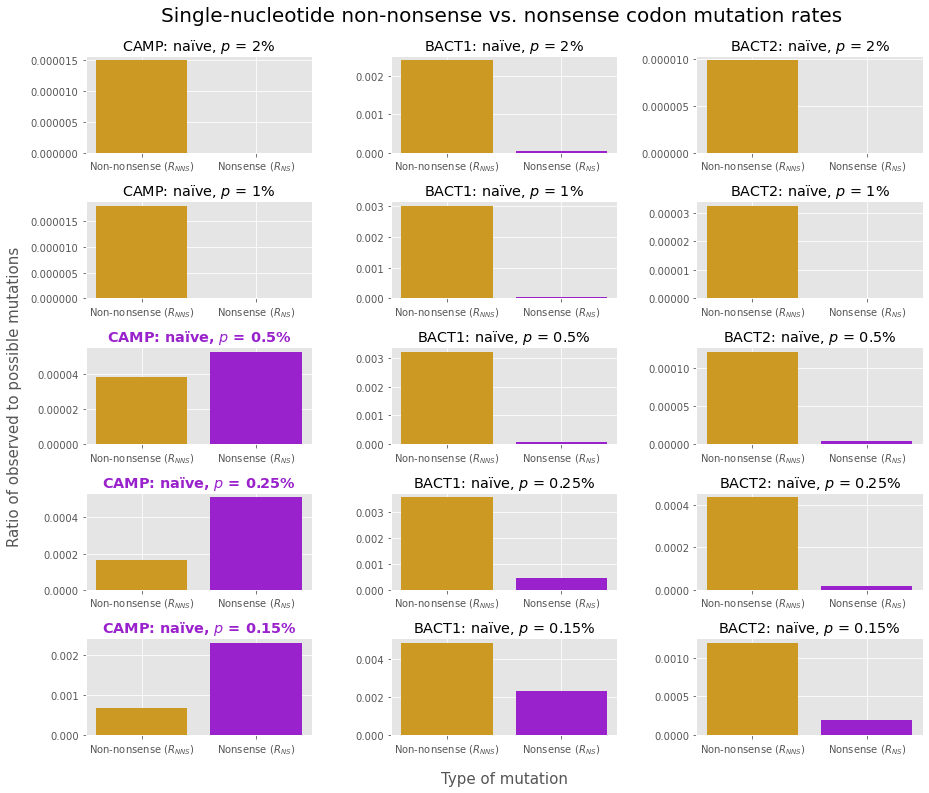

In [64]:
fig2, axes2 = pyplot.subplots(len(percentages), 3, gridspec_kw={"hspace": 0.5, "wspace": 0.35})

for pi, p in enumerate(percentages):
    for si, seq in enumerate(SEQS):
        rnns = p2seq2nonsensevals[p][seq]["nonnonsense"]
        rns = p2seq2nonsensevals[p][seq]["nonsense"]
        axes2[pi, si].bar(
            ["Non-nonsense ($R_{NNS}$)", "Nonsense ($R_{NS}$)"],
            [rnns, rns],
            color=["#cc9922", "#9922cc"]
        )
        
        # Turn off scientific notation on the y-axis' ticks -- for some very small numbers
        # for CAMP's mutation rates, matplotlib will default to scaling the y-axis tick values by 1e-5.
        # See https://stackoverflow.com/a/28373421: the axis="y" argument is needed because by default
        # this'll try to apply this to *both* axes, and the categorical x-axis causes an error.
        axes2[pi, si].ticklabel_format(axis="y", style="plain")
        
        titlecolor = "#000000"
        titleweight = "normal"
        if rnns <= rns:
            titlecolor = "#9922cc"
            titleweight = "semibold"
            
        axes2[pi, si].set_title(f"{seq2name[seq]}: {get_suffix(p)}", color=titlecolor, fontweight=titleweight)
        
        if pi == middle_row and si == 0:
            axes2[pi, si].set_ylabel("Ratio of observed to possible mutations", labelpad=15, fontsize=15)
        
axes2[len(percentages) - 1, 1].set_xlabel("Type of mutation", labelpad=15, fontsize=15)
fig2.suptitle("Single-nucleotide non-nonsense vs. nonsense codon mutation rates", y=0.935, x=0.51, fontsize=20)
fig2.set_size_inches(15, 12.5)
fig2.savefig("figs/nonnonsense-nonsense-snmut-barplots.png", bbox_inches="tight")

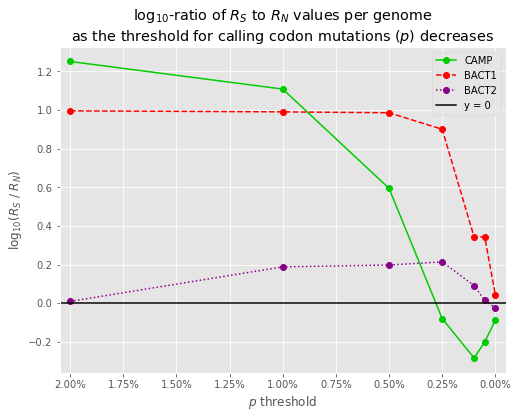

In [37]:
fig, ax = pyplot.subplots(1)

colors = ["#00cc00", "#ff0000", "#880088"]
linestyles = ["-", "--", ":"]
for si, seq in enumerate(SEQS):
    ratios = []
    for pi, p in enumerate(percentages):
        rs = (p2seq2synvals[p][seq]["syn"])
        rn = (p2seq2synvals[p][seq]["nonsyn"])
        ratios.append(log(rs / rn, 10))
    ax.plot(percentages, ratios, label=seq2name[seq], color=colors[si], linestyle=linestyles[si], marker="o")

# use xlim to invert x-axis, so that it goes from high -> low rather than low -> high:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/invert_axes.html
ax.set_xlim(2.05, -0.05)

# Show percentages on the x-axis:
# https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
ax.get_xaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100, decimals=2))

ax.axhline(y=0, color="black", label="y = 0")

ax.set_xlabel("$p$ threshold")
ax.set_ylabel("$\log_{10} ( R_S\  /\  R_N )$")
ax.set_title("$\log_{10}$-ratio of $R_S$ to $R_N$ values per genome\nas the threshold for calling codon mutations ($p$) decreases")
ax.legend()
fig.set_size_inches(8, 6)
fig.savefig("figs/syn-nonsyn-ratios.png", bbox_inches="tight")

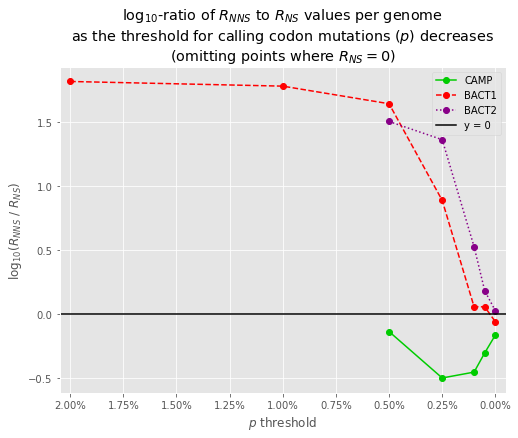

In [38]:
fig, ax = pyplot.subplots(1)

for si, seq in enumerate(SEQS):
    ratios = []
    for pi, p in enumerate(percentages):
        rnns = (p2seq2nonsensevals[p][seq]["nonnonsense"])
        rns = (p2seq2nonsensevals[p][seq]["nonsense"])
        if rnns == 0:
            raise ValueError("HEY MARCUS UPDATE THE PLOT TITLE AND HANDLE THIS CASE")
        if rns > 0:
            ratios.append(log(rnns / rns, 10))
        else:
            ratios.append(None)
    ax.plot(percentages, ratios, label=seq2name[seq], color=colors[si], linestyle=linestyles[si], marker="o")

ax.set_xlim(2.05, -0.05)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100, decimals=2))

ax.axhline(y=0, color="black", label="y = 0")

ax.set_xlabel("$p$ threshold")
ax.set_ylabel("$\log_{10} ( R_{NNS}\  /\  R_{NS} )$")
# If there were any points where R_{NNS} = 0 we should include that in the title, but as the barplots make clear
# no points fit this description
ax.set_title("$\log_{10}$-ratio of $R_{NNS}$ to $R_{NS}$ values per genome\nas the threshold for calling codon mutations ($p$) decreases\n(omitting points where $R_{NS} = 0$)")
ax.legend()
fig.set_size_inches(8, 6)
fig.savefig("figs/nonnonsense-nonsense-ratios.png", bbox_inches="tight")

## Misc. text info about BACT1, to help with explanation

### For the $R_S$ and $R_N$ section

#### Example of rate computation with BACT1

In [39]:
outputtext = fr"""For the {seq2name['edge_1671']} genome
(where $N$ = {seq2total_codon_nt_len['edge_1671']:,}),
there are $J$ = {seq2poss_si['edge_1671']:,} possible synonymous and
$K$ = {seq2poss_ni['edge_1671']:,} possible nonsynonymous single-nucleotide mutations.
%
Using the mutation frequency threshold $p = 0.5\%$,
the {seq2name['edge_1671']} genome contains
$X$ = {p2seq2obs_si[0.5]['edge_1671']:,} synonymous and
$Y$ = {p2seq2obs_ni[0.5]['edge_1671']:,} nonsynonymous single-nucleotide mutations.
%
Thus, the ratio of observed to possible synonymous single-nucleotide mutations
($R_S = X / J = \frac{{{p2seq2obs_si[0.5]['edge_1671']:,}}}{{{seq2poss_si['edge_1671']:,}}}
\approx {p2seq2synvals[0.5]['edge_1671']['syn']:.4f}$)
is much larger than the ratio of observed to possible nonsynonymous single-nucleotide mutations
($R_N = Y / K = \frac{{{p2seq2obs_ni[0.5]['edge_1671']:,}}}{{{seq2poss_ni['edge_1671']:,}}}
\approx {p2seq2synvals[0.5]['edge_1671']['nonsyn']:.4f}$)
for {seq2name['edge_1671']}.
"""
with open("misc-text/bact1-rs-rn-info.tex", "w") as of:
    of.write(f"{outputtext}\endinput")

In [40]:
print(outputtext)

For the BACT1 genome
(where $N$ = 1,947,597),
there are $J$ = 1,250,228 possible synonymous and
$K$ = 4,592,563 possible nonsynonymous single-nucleotide mutations.
%
Using the mutation frequency threshold $p = 0.5\%$,
the BACT1 genome contains
$X$ = 12,941 synonymous and
$Y$ = 4,906 nonsynonymous single-nucleotide mutations.
%
Thus, the ratio of observed to possible synonymous single-nucleotide mutations
($R_S = X / J = \frac{12,941}{1,250,228}
\approx 0.0104$)
is much larger than the ratio of observed to possible nonsynonymous single-nucleotide mutations
($R_N = Y / K = \frac{4,906}{4,592,563}
\approx 0.0011$)
for BACT1.



#### Example of FDR computation with BACT1

In [41]:
fdr = p2seq2synvals[0.5]['edge_1671']['nonsyn'] / 3
outputtext = fr"""For the {seq2name['edge_1671']} genome at $p = 0.5\%$, then,
the FDR would be estimated as $R_N / 3 \approx {fdr:.5f}$.
"""
with open("misc-text/bact1-rs-rn-fdr.tex", "w") as of:
    of.write(f"{outputtext}\endinput")

### For the $R_{NNS}$ and $R_{NS}$ section

In [42]:
# Some unused text I started writing before realizing that it isn't super important probably, but oh
# well the extra assertion is nice to keep in

n = seq2total_codon_nt_len['edge_1671']
s = seq2num_genes['edge_1671']
np = seq2sense_codon_nt_len['edge_1671']
assert np == (n - (3 * s))

print(fr"""
For all genomes, $N' = N - 3S$, where $N$ is the total number of
nucleotides located in all codons (sense and stop), and $S$ is the total number of stop codons
located in all predicted genes throughout the the genome (this number should be equal to the
total number of predicted genes, since each gene should have only a single associated stop codon).
The {seq2name['edge_1671']} genome has $N = {n:,}$,
$3S = {3 * s:,}$, and $N' = {np:,}$,
so $N' = N - S$ holds.
""")


For all genomes, $N' = N - 3S$, where $N$ is the total number of
nucleotides located in all codons (sense and stop), and $S$ is the total number of stop codons
located in all predicted genes throughout the the genome (this number should be equal to the
total number of predicted genes, since each gene should have only a single associated stop codon).
The BACT1 genome has $N = 1,947,597$,
$3S = 5,283$, and $N' = 1,942,314$,
so $N' = N - S$ holds.



In [43]:
# NOTE: we use {{ }} (doubling up on curly braces) in order to escape them --
# https://stackoverflow.com/a/5466478
# We could probs also just split this up into multiple strings but that's woooork

outputtext = fr"""To illustrate this, we again consider
the {seq2name['edge_1671']} genome at the threshold $p = 0.5\%$.
%
In this genome, there are $N'$ = {seq2sense_codon_nt_len['edge_1671']:,} nucleotides
located throughout all sense codons (we ignore stop codons in the reference genome).
%
{seq2name['edge_1671']} has $J$ = {seq2poss_nnsi['edge_1671']:,} possible non-nonsense and
$K$ = {seq2poss_nsi['edge_1671']:,} possible nonsense single-nucleotide mutations.
%
Using $p = 0.5\%$, {seq2name['edge_1671']} contains
$X$ = {p2seq2obs_nnsi[0.5]['edge_1671']:,} non-nonsense and
$Y$ = {p2seq2obs_nsi[0.5]['edge_1671']:,} nonsense single-nucleotide mutations.
%
At $p = 0.5\%$, then, the ratio of observed to possible non-nonsense single-nucleotide mutations
($R_{{NNS}} = X / J = \frac{{{p2seq2obs_nnsi[0.5]['edge_1671']:,}}}{{{seq2poss_nnsi['edge_1671']:,}}}
\approx {p2seq2nonsensevals[0.5]['edge_1671']['nonnonsense']:.4f}$)
is much larger than the ratio of observed to possible nonsynonymous single-nucleotide mutations
($R_{{NS}} = Y / K = \frac{{{p2seq2obs_nsi[0.5]['edge_1671']:,}}}{{{seq2poss_nsi['edge_1671']:,}}}
\approx {p2seq2nonsensevals[0.5]['edge_1671']['nonsense']:.6f}$)
for {seq2name['edge_1671']}.
"""
with open("misc-text/bact1-rnns-rns-info.tex", "w") as of:
    of.write(f"{outputtext}\endinput")

In [44]:
print(outputtext)

To illustrate this, we again consider
the BACT1 genome at the threshold $p = 0.5\%$.
%
In this genome, there are $N'$ = 1,942,314 nucleotides
located throughout all sense codons (we ignore stop codons in the reference genome).
%
BACT1 has $J$ = 5,525,851 possible non-nonsense and
$K$ = 301,091 possible nonsense single-nucleotide mutations.
%
Using $p = 0.5\%$, BACT1 contains
$X$ = 17,806 non-nonsense and
$Y$ = 22 nonsense single-nucleotide mutations.
%
At $p = 0.5\%$, then, the ratio of observed to possible non-nonsense single-nucleotide mutations
($R_{NNS} = X / J = \frac{17,806}{5,525,851}
\approx 0.0032$)
is much larger than the ratio of observed to possible nonsynonymous single-nucleotide mutations
($R_{NS} = Y / K = \frac{22}{301,091}
\approx 0.000073$)
for BACT1.

